In [1]:
#!/usr/bin/env python

from os.path import isfile, join
import matplotlib.pyplot as plt
from datetime import datetime
from os import listdir
import pandas as pd
import json
import yaml
import re

import numpy as np
import math
from sklearn import metrics
from sklearn.metrics import (adjusted_rand_score,
                             normalized_mutual_info_score,
                             fowlkes_mallows_score,
                             homogeneity_completeness_v_measure)
from ripser import ripser
from fastdtw import fastdtw
import fast_pl_py
import statsmodels.api as sm


def getFilenames(path):
    return [path+f for f in listdir(path) if isfile(join(path, f))]


# Get argus data
# arguspath = "data/argus/csv/"
# argusCSVs = getFilenames(arguspath)

# Get pcap data
pcappath = "../data/csv/"
pcapCSVs = getFilenames(pcappath)

# Get server logs
logpath = "../data/experiment0-0.01/shadow.data/hosts/mymarkovservice0/"
logs = getFilenames(logpath)

# Combine all locations
# data = argusCSVs + pcapCSVs + logs
data = pcapCSVs + logs

df = pd.read_csv(pcapCSVs[0])


class PrivacyScope:

    def __init__(self, filenames, name):
        self.name = name
        self.filenames = filenames
        self.time_format = '%b %d, %Y %X.%f'
        self.time_cut_tail = -7
        self.time_col = 'frame.time'
        self.filter_func = lambda df, args: df
        self.df = None
        self.ip_search_enabled = False
        self.cache_search_enabled = False
        self.cache_timing = pd.Timedelta("300 seconds")
        self.generated = False

    def __repr__(self):
        return str(self)

    def __str__(self):
        return self.name

    def start_time(self):
        return self.as_df().index.min()

    def set_offset(self, timeoffset):
        self.timeoffset = timeoffset
        self.as_df()
        self.df.index += timeoffset

    def set_index(self, col_name):
        df = self.as_df()
        df.set_index(col_name, inplace=True)
        self.df = df
        return df

    def process_log(self, fn, sep='\t', cols=["time", "format", "data"]):
        df = pd.read_csv(fn, sep=sep, names=cols)
        m = pd.json_normalize(df["data"].apply(json.loads))
        df.drop(["data"], axis=1, inplace=True)
        df = pd.concat([df, m], axis=1, sort=False)
        return df

    def as_df(self, filenames=None):
        if self.df is not None:
            return self.df
        if filenames is None:
            filenames = self.filenames
        df = pd.DataFrame()
        for f in filenames:
            if f.endswith(".csv"):
                ddf = pd.read_csv(f)
            elif f.endswith("stdout"):
                ddf = self.process_log(f)
            df = pd.concat([df, ddf])
        self.df = df
        self.format_time_col()
        return self.df

    def get_ts(self):
        return None

    def format_time_col(self):
        if self.time_format == 'epoch':
            self.df[self.time_col] = \
                    self.df[self.time_col].apply(
                            lambda x: datetime.fromtimestamp(float(x)))
        else:
            self.df[self.time_col] = \
                    self.df[self.time_col].apply(
                            lambda x: datetime.strptime(
                                x[:self.time_cut_tail], self.time_format))
        return self.df

    def pcap_only(self):
        r = re.compile(".*data/csv.*")
        return list(filter(r.match, self.filenames))

    def pcap_df(self):
        assert self.df is None
        return self.as_df(filenames=self.pcap_only())

    def set_filter(self, filter_func):
        self.filter_func = filter_func

    def run_filter(self, args):
        return self.filter_func(self.as_df(), args)

    def filterByIP(self, ip, run_filter=True, args=None):
        df = self.as_df()
        if run_filter:
            df = self.run_filter(args)
        return df[((df['ip.dst'] == ip) |
                   (df['ip.src'] == ip))]

    def filterByCache(self, ip, cache_data, run_filter=True, args=None):
        df = self.as_df()
        if run_filter:
            df = self.run_filter(args)

        df_times = df.index.values.tolist()
        df_times = [pd.to_datetime(t) for t in df_times]

        input_times = cache_data.index.values.tolist()
        input_times = [pd.to_datetime(t) for t in input_times]

        keepers = [False] * len(df_times)
        idx = 0
        stop = len(input_times)
        for i in range(0, len(df_times)):
            if idx >= stop:
                break
            diff = input_times[idx] - df_times[i]
            if diff <= pd.Timedelta(0):
                idx += 1
            elif diff < self.cache_timing:
                keepers[i] = True

        return df[keepers]

    def search(self, ip=None, cache_data=None):
        matches = []
        if self.ip_search_enabled and ip is not None:
            matches += [self.filterByIP(ip)]
        if self.cache_search_enabled and cache_data is not None:
            matches += [self.filterByCache(ip, cache_data)]
        return matches

    def remove_zero_var(self, cutoff=0.01):
        df = self.as_df()

        numeric_cols = df.select_dtypes(include=np.number)
        cols_to_drop = numeric_cols.columns[(numeric_cols.std() <= cutoff) |
                                            (numeric_cols.std().isna())]\
                                                    .tolist()
        df_filtered = df.drop(cols_to_drop, axis=1)
        self.df = df_filtered

    def remove_features(self, bad_features):
        df = self.as_df()
        df.drop(bad_features, inplace=True, axis=1)
        self.df = df

    def adjust_time_scale(self, offset, scale):
        df = self.as_df()
        df[self.time_col] = df[self.time_col].apply(lambda x: int(x.timestamp()))
        df[self.time_col] = (df[self.time_col] - offset) * scale + offset
        col = df[self.time_col]
        self.df = df
        self.time_format = 'epoch'
        self.format_time_col()
        self.df = self.df.set_index(self.time_col)
        self.df[self.time_col] = col


# Basic Scopes

# Get all clients and ISP dns scope
r = re.compile(r".*isp.csv|.*group[0-9]*user[0-9]*-(?!127\.0\.0\.1)[0-9]*.[0-9]*.[0-9]*.[0-9]*..csv")
ISP_scope = PrivacyScope(list(filter(r.match, data)), "ISP")


# Access to public resolver scope
r = re.compile(r".*isp.*.csv")
Access_resolver = PrivacyScope(list(filter(r.match, data)), "Access_resolver")

r = re.compile(r"(.*tld).*.csv")
tld = PrivacyScope(list(filter(r.match, data)), "TLD")

r = re.compile(r"(.*root).*.csv")
root = PrivacyScope(list(filter(r.match, data)), "root")

r = re.compile(r"(.*sld).*.csv")
sld = PrivacyScope(list(filter(r.match, data)), "SLD")

# Access Tor Scope
r = re.compile(r".*group[0-9]*user[0-9]*-(?!127\.0\.0\.1)[0-9]*.[0-9]*.[0-9]*.[0-9]*..csv")
Access_tor = PrivacyScope(list(filter(r.match, data)), "Access_tor")

# Server Public Scope
r = re.compile(r".*myMarkovServer0*-(?!127\.0\.0\.1)[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*.csv")
Server_scope = PrivacyScope(list(filter(r.match, data)), "Server_of_interest")

# tor Exit scope
r = re.compile(r".*exit.*")
Tor_exit_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_exit")

# tor Guard scope
r = re.compile(r".*guard.*")
Tor_guard_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_guard")

# tor Relay scope
r = re.compile(r".*relay.*")
Tor_relay_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_relay")

# tor Middle scope
r = re.compile(r".*middle.*")
Tor_middle_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_middle")

# tor 4uthority scope
r = re.compile(r".*4uthority.*")
Tor_4uthority_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_4uthority")

# resolver scope
r = re.compile(r".*resolver.*")
resolver = PrivacyScope(list(filter(r.match, data)), "resolver")


def df_to_ts(df):
    df.loc[:, 'count'] = 1
#    tmp = df.index.to_frame()
    if not isinstance(df.index, pd.DatetimeIndex):
        print(df)
    tmp = df.resample('1S').sum(numeric_only=True).infer_objects()
    tmp = tmp.reset_index()
    return tmp


print("Scopes created")


def get_GNS3_offset():
    # Read the YAML file
    with open('../data/experiment0-0.01/shadow.config.yaml', 'r') as file:
        data = yaml.safe_load(file)

    # Extract the value
    time = data['hosts']['group0user0']['processes'][2]['args'].split()[1]
    return int(time)


def get_start_time(scopes):
    df = pd.concat([scope.as_df() for scope in scopes])
    start_time = df.head(1).index.to_numpy()[0]
    return pd.to_datetime(start_time)


GNS3_scopes = [resolver,
               sld,
               tld,
               root]

GNS3_offset = get_GNS3_offset()
scale = 10
for scope in GNS3_scopes:
    scope.pcap_df()
    scope.adjust_time_scale(GNS3_offset, scale)
GNS3_starttime = get_start_time(GNS3_scopes)


Scopes created


In [2]:
Access_resolver.pcap_df()
Access_resolver.adjust_time_scale(GNS3_offset, scale)

In [3]:
ar = Access_resolver.as_df()
start_exp = ar.index.min()
ar = ar[(ar['ip.proto'] == 6) & (ar['tcp.dstport'] == 80) & (ar['ip.len']>200)]
start_http = ar.index.min()
delay = start_http - GNS3_starttime
delay

Timedelta('0 days 00:06:30')

In [4]:
# service log scope
r = re.compile(".*mymarkovservice*.*py.*stdout")
chatlog = PrivacyScope(list(filter(r.match, data)), "chatlogs")
chatlog.time_col = "time"
chatlog.time_cut_tail = 0
chatlog.time_format = 'epoch'
# Subtract an extra second for buffer room to ensure chatlog happens after DNS
chatlog.set_index(chatlog.time_col)
chatlog.set_offset(GNS3_starttime - chatlog.start_time() + delay)


window = pd.Timedelta("300 seconds")  # cache size but maybe smaller

print("GNS3_starttime: " + str(GNS3_starttime))
print("chatlog.start_time(): " + str(chatlog.start_time()))
# Ensure chat happens after DNS traffic
assert chatlog.start_time() - GNS3_starttime > pd.Timedelta(seconds=0)
assert chatlog.start_time() - ar.index.min() == pd.Timedelta(seconds=0)
chatlog.start_time() - ar.index.min() == pd.Timedelta(seconds=0)

GNS3_starttime: 2023-06-14 03:57:21
chatlog.start_time(): 2023-06-14 04:03:51


True

In [5]:
ar

,frame.number,ip.src,ip.dst,ip.proto,ip.len,tcp.srcport,tcp.dstport,tcp.connection.syn,tcp.ack,tcp.seq,...,frame.time_relative,frame.time_delta,tcp.time_relative,tcp.time_delta,tcp.payload,dns.qry.name,dns.opt.client.addr4,dns.opt.client.addr6,dns.opt.client.addr,frame.time
frame.time,,,,,,,,,,,,,,,,,,,,,
2023-06-14 04:03:51,178,102.0.0.12,101.0.0.10,6.0,207.0,57302.0,80.0,NaN,1.0,1.0,...,32.275179,0.000060,1.073856,0.000060,474554202f7265736f75726365302e68746d6c20485454...,NaN,NaN,NaN,NaN,NaN
2023-06-14 04:03:51,211,102.0.0.12,101.0.0.10,6.0,207.0,57312.0,80.0,NaN,1.0,1.0,...,32.456707,0.000019,0.026847,0.000019,474554202f7265736f75726365302e68746d6c20485454...,NaN,NaN,NaN,NaN,NaN
2023-06-14 04:04:01,264,102.0.0.12,101.0.0.10,6.0,207.0,57326.0,80.0,NaN,1.0,1.0,...,32.639196,0.000060,0.026864,0.000060,474554202f7265736f75726365302e68746d6c20485454...,NaN,NaN,NaN,NaN,NaN
2023-06-14 04:04:01,332,102.0.0.12,101.0.0.10,6.0,207.0,57338.0,80.0,NaN,1.0,1.0,...,32.821959,0.000015,0.026857,0.000015,474554202f7265736f75726365302e68746d6c20485454...,NaN,NaN,NaN,NaN,NaN
2023-06-14 04:04:01,396,102.0.0.14,101.0.0.10,6.0,207.0,39818.0,80.0,NaN,1.0,1.0,...,33.004968,0.000093,0.025922,0.000093,474554202f7265736f75726365302e68746d6c20485454...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-14 06:11:11,933404,102.0.0.30,101.0.0.10,6.0,207.0,49372.0,80.0,NaN,1.0,1.0,...,796.284865,0.000018,0.027201,0.000157,474554202f7265736f75726365342e68746d6c20485454...,NaN,NaN,NaN,NaN,NaN
2023-06-14 06:11:11,933577,102.0.0.30,101.0.0.10,6.0,207.0,49384.0,80.0,NaN,1.0,1.0,...,796.468669,0.000053,0.026995,0.000053,474554202f7265736f75726365342e68746d6c20485454...,NaN,NaN,NaN,NaN,NaN
2023-06-14 06:20:11,1007746,102.0.0.16,101.0.0.10,6.0,207.0,33812.0,80.0,NaN,1.0,1.0,...,850.421570,0.000024,0.027483,0.000024,474554202f7265736f75726365312e68746d6c20485454...,NaN,NaN,NaN,NaN,NaN


In [6]:
# # Viz
# # importing Libraries
# plt.style.use('default')
# # code
# # Visualizing The Open Price of all the stocks
# # to set the plot size
# plt.figure(figsize=(16, 8), dpi=150)
# # using plot method to plot open prices.
# # in plot method we set the label and color of the curve.
# chat_ts = df_to_ts(chatlog.as_df())['count']

# r_ts = df_to_ts(ar)['count']

# chat_ts /= chat_ts.max()
# r_ts /= r_ts.max()

# r_ts.plot(label="resolver")
# chat_ts.plot(label="chat")

# plt.title('Requests per second')

# # adding Label to the x-axis
# plt.xlabel('Time')
# plt.ylabel('Requests (seconds)')

# # adding legend to the curve
# plt.legend()

In [7]:
# detect and remove solo quries
# these can easily be handled on their own
# as only 1 device is accessing the network at that moment
def detect_solo(df_list):
    new_df = df_list[df_list['ip.src'].ne(df_list['ip.src'].shift())]
    new_df['index_col'] = new_df.index
    new_df['diff'] = new_df['index_col'].diff()
    new_df = new_df[new_df['diff'] > window]
    solo_ips = new_df['ip.src'].unique()
    return solo_ips


def handle_solo(solo):
    print("IPs that must trigger a cache miss: " + str(solo))


def solo_pipeline(df_list):
    fil = df_list.loc[:, ['ip.src']]
    solo = detect_solo(fil)
    handle_solo(solo)
    return solo


def combineScopes(dfs):
    if len(dfs) < 1:
        return dfs
    return pd.concat(dfs)


def scopesToTS(dfs):
    output = []
    for df in dfs:
        if len(df) < 2:
            continue
        output += scopeToTS(df)
    return output


def scopeToTS(df, time_col):
    return df_to_ts(df.copy(deep=True)).set_index(time_col)


def scope_label(df, scope_name):
    for col in df.columns:
        df[col + "_" + scope_name] = df[col]
    df["scope_name"] = scope_name
    return df


# Setup filters for different scopes
evil_domain = 'evil.dne'
DNS_PORT = 17.0
DOT_PORT = 853


def dns_filter(df, ip):
    if ('dns.qry.name' in df.columns and 'tcp.dstport' in df.columns):
        return df[(df['dns.qry.name'] == evil_domain)
                  | (df['dns.qry.name'].isna())
                  & (df['tcp.dstport'] == DOT_PORT)]
    else:
        return df[(df['dns.qry.name'] == evil_domain)
                  | (df['dns.qry.name'].isna())]


resolver.set_filter(dns_filter)
root.set_filter(dns_filter)
tld.set_filter(dns_filter)
sld.set_filter(dns_filter)

resolver.ip_search_enabled = True
resolver.cache_search_enabled = False

root.ip_search_enabled = True
root.cache_search_enabled = True

sld.ip_search_enabled = True
sld.cache_search_enabled = True

tld.ip_search_enabled = True
tld.cache_search_enabled = True

TCP_PROTO = 6


# def tor_filter(df, ip):
#     return df[(df['tcp.len'] > 500) & (df['ip.proto'] == TCP_PROTO)]


# Access_tor.set_filter(tor_filter)

# Access_tor.ip_search_enabled = True
# Access_tor.cache_search_enabled = True


# Cluster DNS
# Create ts for each IP
resolv_df = resolver.as_df()
resolv_df_filtered = resolv_df[resolv_df['tcp.dstport'] == DOT_PORT]
infra_ip = ['172.20.0.11', '172.20.0.12', '192.168.150.10', '172.20.0.10']
ips_seen = resolv_df_filtered['ip.src'].unique()
IPs = list(set(ips_seen) - set(infra_ip))
flows_ip = {}
flows_ts_ip_scoped = {}
flows_ts_ip_total = {}
first_pass = resolv_df_filtered[((~resolv_df_filtered['ip.src'].isin(infra_ip)))
                                & (resolv_df_filtered['dns.qry.name'] == evil_domain)]
solo = solo_pipeline(first_pass)

# Add all scope data to IPs found in resolver address space
# This should be a valid topo sorted list
# of the scopes (it will be proccessed in order)
scopes = [resolver, root, tld, sld]  # , Access_tor]
bad_features = ['tcp.dstport', 'tcp.srcport', 'udp.port', 'tcp.seq']
for scope in scopes:
    scope.remove_features(bad_features)
    scope.remove_zero_var()
cache_window = window  # see above
print("scopes: " + str(scopes))
print("cache window: " + str(cache_window))

for ip in IPs:
    # Don't add known infra IPs or users that can are solo communicaters
    if ip in infra_ip or ip in solo:
        continue
    flows_ip[ip] = pd.DataFrame()
    flows_ts_ip_scoped[ip] = pd.DataFrame()
    flows_ts_ip_total[ip] = pd.DataFrame()
    for scope in scopes:
        # Find matches
        matches = scope.search(ip, flows_ip[ip])

        # Update df for ip
        combined_scope = combineScopes(matches)
        combined_scope = scope_label(combined_scope, scope.name)
        combined_scope["scope_name"] = scope.name
        flows_ip[ip] = combineScopes([flows_ip[ip], combined_scope])

        # update ts for ip
        new_ts_matches = scopeToTS(combined_scope, scope.time_col)
        if len(new_ts_matches) == 0:
            continue
        new_ts_matches["scope_name"] = scope.name
        flows_ts_ip_scoped[ip] = combineScopes([flows_ts_ip_scoped[ip],
                                                new_ts_matches])
    if len(flows_ip[ip]) > 0:
        flows_ts_ip_total[ip] = scopeToTS(flows_ip[ip], scope.time_col)

        # order df by time
        # flows_ip[ip] = flows_ip[ip].set_index('frame.time')

        # sort combined df by timestamp
        flows_ip[ip].sort_index(inplace=True)
        flows_ts_ip_scoped[ip].sort_index(inplace=True)
        flows_ts_ip_total[ip].sort_index(inplace=True)

        # Preserve time col to be used for automated feautre engineering
        flows_ip[ip]['frame.time'] = flows_ip[ip].index
        flows_ts_ip_total[ip]['frame.time'] = flows_ts_ip_total[ip].index

        # remove nans with 0
        flows_ip[ip].fillna(0, inplace=True)
        flows_ts_ip_scoped[ip].fillna(0, inplace=True)
        flows_ts_ip_total[ip].fillna(0, inplace=True)

        # label scope col as category
        flows_ip[ip]["scope_name"] = flows_ip[ip]["scope_name"].astype('category')
        flows_ts_ip_scoped[ip]["scope_name"] = flows_ts_ip_scoped[ip]["scope_name"].astype('category')


# In[28]:




IPs that must trigger a cache miss: []
scopes: [resolver, root, TLD, SLD]
cache window: 0 days 00:05:00


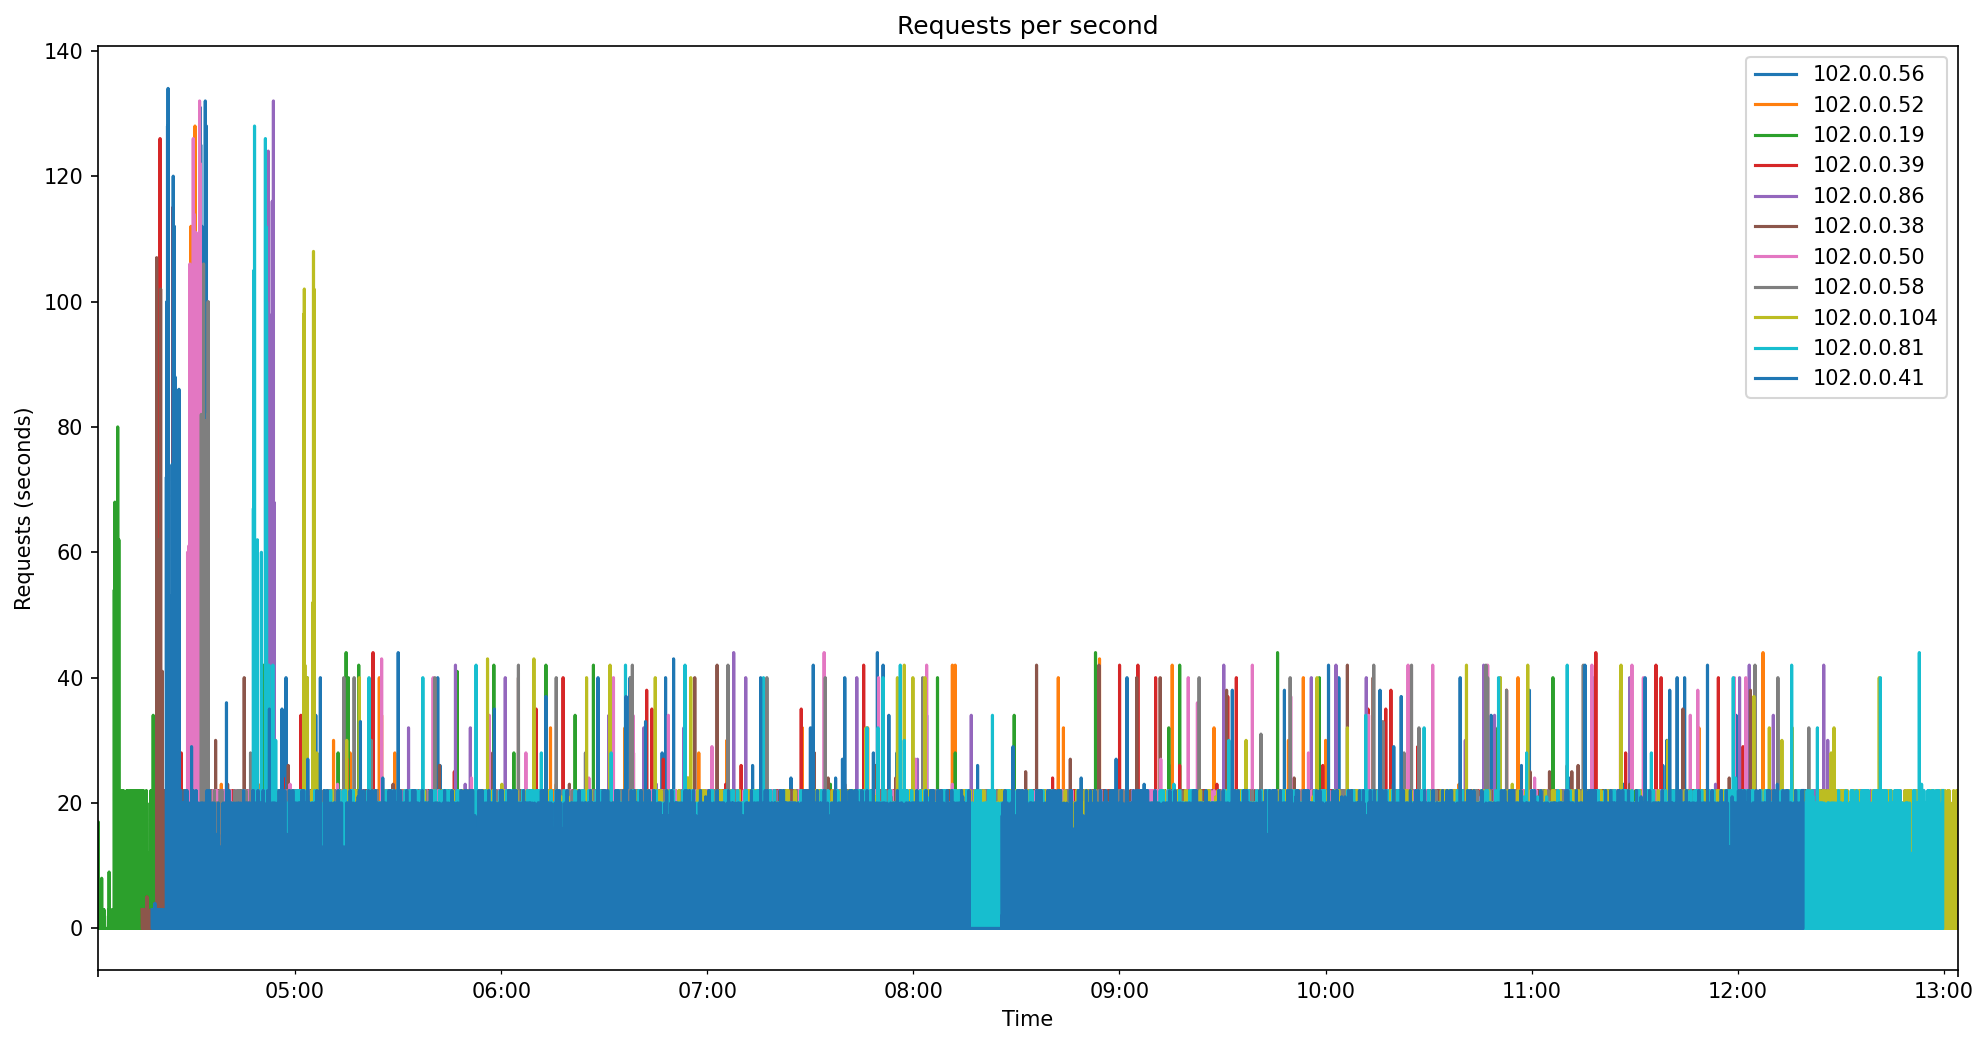

In [8]:
# Viz
# importing Libraries
plt.style.use('default')
# code
# Visualizing The Open Price of all the stocks
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.

total = 0
for f in flows_ts_ip_total:
    if total > 10:
        break
    total += 1
    flows_ts_ip_total[f]['count'].plot(label=f)

plt.title('Requests per second')

# adding Label to the x-axis
plt.xlabel('Time')
plt.ylabel('Requests (seconds)')

# adding legend to the curve
plt.legend()

In [9]:
flows_ts_ip_total['102.0.0.94']

,frame.number,ip.proto,ip.len,tcp.ack,tcp.len,frame.time_relative,frame.time_delta,tcp.time_relative,tcp.time_delta,frame.number_resolver,...,ip.len_TLD,frame.time_relative_TLD,frame.time_delta_TLD,frame.number_SLD,ip.proto_SLD,ip.len_SLD,frame.time_relative_SLD,frame.time_delta_SLD,count,frame.time
frame.time,,,,,,,,,,,,,,,,,,,,,
2023-06-14 04:50:01,995,0.0,0.0,0.0,0.0,639.438240,1.712444,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2023-06-14 04:50:01
2023-06-14 04:50:02,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-14 04:50:02
2023-06-14 04:50:03,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-14 04:50:03
2023-06-14 04:50:04,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-14 04:50:04
2023-06-14 04:50:05,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-14 04:50:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-14 12:48:27,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-14 12:48:27
2023-06-14 12:48:28,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-14 12:48:28
2023-06-14 12:48:29,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-14 12:48:29


In [10]:
root_df = root.as_df()
root_df[~root_df['ip.len'].isna() & root_df['dns.qry.name']].head(50)

,frame.number,ip.src,ip.dst,ip.proto,ip.len,frame.time_relative,frame.time_delta,dns.qry.name
frame.time,,,,,,,,
2023-06-14 04:01:01,13,172.20.0.10,172.20.0.11,17.0,87.0,25.455839,0.000109,ns1.rootserver.net
2023-06-14 04:01:01,14,172.20.0.10,172.20.0.11,17.0,87.0,25.455870,0.000031,ns1.rootserver.net
2023-06-14 04:01:01,17,172.20.0.11,172.20.0.10,17.0,103.0,25.456596,0.000183,ns1.rootserver.net
2023-06-14 04:01:01,18,172.20.0.11,172.20.0.10,17.0,103.0,25.456635,0.000039,ns1.rootserver.net
2023-06-14 04:01:01,19,172.20.0.10,172.20.0.11,17.0,96.0,25.457154,0.000519,ns1.tld.net
2023-06-14 04:01:01,20,172.20.0.11,172.20.0.10,17.0,96.0,25.457501,0.000347,ns1.tld.net
2023-06-14 04:03:41,51,192.168.150.10,172.20.0.10,17.0,56.0,41.297229,0.009996,<Root>
2023-06-14 04:03:41,52,172.20.0.10,192.168.150.10,17.0,197.0,41.297639,0.000410,<Root>
2023-06-14 04:03:41,53,192.168.150.10,172.20.0.10,17.0,60.0,41.327477,0.029838,dne


In [11]:
root_df[root_df['dns.qry.name'] == 'dne']

,frame.number,ip.src,ip.dst,ip.proto,ip.len,frame.time_relative,frame.time_delta,dns.qry.name
frame.time,,,,,,,,
2023-06-14 04:03:41,53,192.168.150.10,172.20.0.10,17.0,60.0,41.327477,0.029838,dne
2023-06-14 04:03:41,55,172.20.0.10,192.168.150.10,17.0,224.0,41.327784,0.000282,dne
2023-06-14 04:08:51,90,192.168.150.10,172.20.0.10,17.0,60.0,72.016520,0.029728,dne
2023-06-14 04:08:51,93,172.20.0.10,192.168.150.10,17.0,224.0,72.016946,0.000201,dne
2023-06-14 04:14:01,131,192.168.150.10,172.20.0.10,17.0,60.0,103.099595,0.000033,dne
2023-06-14 04:14:01,133,172.20.0.10,192.168.150.10,17.0,224.0,103.100178,0.000324,dne
2023-06-14 04:19:11,180,192.168.150.10,172.20.0.10,17.0,60.0,134.766863,0.332137,dne
2023-06-14 04:19:11,181,172.20.0.10,192.168.150.10,17.0,224.0,134.767167,0.000304,dne
2023-06-14 04:24:21,232,192.168.150.10,172.20.0.10,17.0,60.0,164.972878,0.000031,dne


In [12]:
chatlog.as_df()

,format,username,text
time,,,
2023-06-14 04:03:51.000,application/json,/tordata/config/group_0_user_2,It's this line that tells me everything I need...
2023-06-14 04:04:01.101,application/json,/tordata/config/group_0_user_2,"While I disagree with the weapon complaint, I ..."
2023-06-14 04:04:01.301,application/json,/tordata/config/group_0_user_2,Yep. Weapons breaking isn't a big deal at all....
2023-06-14 04:04:11.000,application/json,/tordata/config/group_0_user_3,Thank you for taking a balanced point of view....
2023-06-14 04:04:11.000,application/json,/tordata/config/group_0_user_4,"Judging by his Horizon score, I'm guessing he ..."
...,...,...,...
2023-06-14 05:44:21.200,application/json,/tordata/config/group_1_user_1,"They are the resistance from TP, an organisati..."
2023-06-14 05:44:21.400,application/json,/tordata/config/group_1_user_1,[Done.](https://i.imgur.com/lizacrc.jpg) I pos...
2023-06-14 05:44:21.600,application/json,/tordata/config/group_1_user_1,I think those are the actual goddesses in this...


In [ ]:

def ip_to_group(ip):
    if ip.split(".")[0] != '101':
        return -1
    return math.floor((int(ip.split(".")[-1])-2) / 5)


def get_real_label(dic):
    data = dic.keys()
    result = np.array([ip_to_group(xi) for xi in data])
    return result


# compute cluster purity
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


def weighted_purity(true_labels, found_labels):
    s = 0
    total = 0
    for c in true_labels.unique():
        selection = df[df['cluster'] == c]
        p = purity_score(selection['real_label'], selection['cluster'])
        total += len(selection)
        s += p * len(selection)
    return s/total


answers = get_real_label(flows_ts_ip_total)


def gpt_cluster_metrics(true_labels, found_labels):
    # Calculate the Adjusted Rand Index
    ari = adjusted_rand_score(true_labels, found_labels)
    ari_range = (-1, 1)
    ari_ideal = 1

    # Calculate the Normalized Mutual Information
    nmi = normalized_mutual_info_score(true_labels, found_labels)
    nmi_range = (0, 1)
    nmi_ideal = 1

    # Calculate the Fowlkes-Mallows Index
    fmi = fowlkes_mallows_score(true_labels, found_labels)
    fmi_range = (0, 1)
    fmi_ideal = 1

    # Calculate homogeneity, completeness, and V-measure
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, found_labels)
    hcv_range = (0, 1)
    hcv_ideal = 1

    # Print the results
    print(f"Adjusted Rand Index: {ari:.4f} [range: {ari_range}, ideal: {ari_ideal}]")
    print(f"Normalized Mutual Information: {nmi:.4f} [range: {nmi_range}, ideal: {nmi_ideal}]")
    print(f"Fowlkes-Mallows Index: {fmi:.4f} [range: {fmi_range}, ideal: {fmi_ideal}]")
    print(f"Homogeneity: {homogeneity:.4f} [range: {hcv_range}, ideal: {hcv_ideal}]")
    print(f"Completeness: {completeness:.4f} [range: {hcv_range}, ideal: {hcv_ideal}]")
    print(f"V-measure: {v_measure:.4f} [range: {hcv_range}, ideal: {hcv_ideal}]")


def my_dtw(ts1, ts2):
    distance, path = fastdtw(ts1, ts2)
    return distance


def my_dist(ts1, ts2, ip1="", ip2=""):
    return my_pl_ts(ts1, ts2, ip1, ip2)


def rip_ts(window, dim, skip, data, thresh=float("inf")):
    for_pl = {}
    for i in range(0, len(data)-window+1, skip):
        diagrams = ripser(data[i:i+window], maxdim=dim, thresh=thresh)['dgms']
        for_pl[i] = diagrams[dim]
    return for_pl


def tda_trans(pairs, k=2, debug=False):
    pairs = [(x[0], x[1]) for x in pairs]
    return fast_pl_py.pairs_to_l2_norm(pairs, k, debug)


class TDA_Parameters:
    def __init__(self, dim, window, skip, k, thresh):
        self.dim = dim
        self.window = window
        self.skip = skip
        self.k = k
        self.thresh = thresh


def ts_to_tda(data, header="", params=TDA_Parameters(0, 3, 1, 2, float("inf")), debug=False):
    data = data.astype(float)

    # compute birth death pairs
    rip_data = rip_ts(params.window, params.dim, params.skip, data, thresh=params.thresh)
    new_ts = [tda_trans(pairs, params.k, debug) for i, pairs in rip_data.items()]
    return pd.DataFrame({'tda_pl': new_ts}, index=data.index[:len(new_ts)])


def my_pl_ts(ts1, ts2, ip1, ip2):
    return my_dtw(ts1, ts2)


def calc_dist_matrix(samples, my_dist, multi_to_single=lambda x: x):
    # create a list of dataframe values
    X = [multi_to_single(df.to_numpy(), ip) for ip, df in samples.items()]
    n_samples = len(X)
    dist_mat = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            d = my_dist(X[i], X[j], i, j)
            dist_mat[i, j] = d
            dist_mat[j, i] = d
    return squareform(dist_mat)


def cast_col(col: pd.Series) -> pd.Series:
    if col.dtype == 'object':
        if all([is_float(x) for x in col]):
            return col.astype(float)
        elif all([is_int(x) for x in col]):
            return col.astype(float)
        elif all([is_date(x) for x in col]):
            return pd.Series(pd.to_datetime(col)).astype(float)
        else:
            return col.astype(str)
    elif np.issubdtype(col.dtype, np.datetime64):
        return col.astype(np.int64)
    else:
        return col.astype(float)


def is_float(s: str) -> bool:
    try:
        float(s)
        return True
    except ValueError:
        return False


def is_int(s: str) -> bool:
    try:
        int(s)
        return True
    except ValueError:
        return False


def is_date(s: str) -> bool:
    try:
        pd.to_datetime(s)
        return True
    except ValueError:
        return False


def cast_columns(df):
    for col in df.columns:
        df[col] = cast_col(df[col])
    return df


def get_chat_logs(scope):
    df = scope.as_df()
    df["text_len"] = df["text"].apply(len)
    users = df["username"].unique()
    client_log = {}
    for user in users:
        client_log[user] = df_to_ts(df[df["username"] == user]).set_index('time')
    return client_log


client_chat_logs = get_chat_logs(chatlog)


def ip_to_user(ip, group_size=5, starting=10):
    local_net = int(ip.split(".")[-1]) - starting
    user = local_net % group_size
    group = math.floor(local_net/group_size)
    return '/tordata/config/group_' + str(group) + "_user_" + str(user)


# https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python
# from scipy import signal

def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))
    c = np.correlate(p, q, 'full')
    return c


def ccf_plot(lags, ccf):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% \
    confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x=0, color='black', lw=1)
    ax.axhline(y=0, color='black', lw=1)
    ax.axhline(y=np.max(ccf), color='blue', lw=1,
               linestyle='--', label='highest +/- correlation')
    ax.axhline(y=np.min(ccf), color='blue', lw=1,
               linestyle='--')
    ax.set(ylim=[-1, 1])
    ax.set_title('Cross Correlation', weight='bold', fontsize=15)
    ax.set_ylabel('Correlation Coefficients', weight='bold',
                  fontsize=12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize=12)
    plt.legend()


def ccf_calc(sig1, sig2):
    corr = sm.tsa.stattools.ccf(sig2, sig1, adjusted=False)

    # Remove padding and reverse the order
    return corr[0:(len(sig2)+1)][::-1]


def cross_cor(ts1, ts2, debug=False, max_offset=300, only_positive=True):
    # ensure format is correct (only keep first col
    # ts1_values = ts1['count'] # ts1.iloc[:,0]
    # ts2_values = ts2['count'] # ts2.iloc[:,0]

    # Calculate values
    # print(ts1)
    ccf = ccf_calc(ts1, ts2)
    # lags = signal.correlation_lags(len(ts1_values), len(ts2_values))

    # keep only positive lag values
    # Not needed with stats packate
    # if only_positive:
    #     ccf = ccf[lags >= 0]
    #     lags = lags[lags >= 0]

    # ccf = ccf[:min(len(ccf), max_offset)]

    # find best
    best_cor = max(ccf)
    best_lag = np.argmax(ccf)

    if debug:
        print('best cross correlation: ' + str(best_cor) + " at time lag: " + str(best_lag))
        print(len(ccf))
        print(ccf)
        ccf_plot(range(len(ccf)), ccf)
    # print(ccf)
    # assert best_cor >= -1 and best_cor <= 1
    return best_cor, best_lag


def compare_ts(ts1, ts2, debug=False):
    # dtw_classic, path_classic = dtw(ts1, ts2, dist='square',
    #                             method='classic', return_path=True)
    # return dtw_classic
    # print(ts1)
    # print(ts2)
    # dist, lag = cross_cor(pd.Series(ts1), pd.Series(ts2))
    dist, lag = cross_cor(ts1, ts2, debug=debug)
    # assert dist >= -1 and dist <= 1
    dist = dist * -1  # flip for use as distance metric
    # assert dist >= -1 and dist <= 1
    return dist, lag


def normalize_ts(ts):
    ts = (ts-ts.min())/(ts.max()-ts.min())
    return ts.fillna(0)


def compare_ts_reshape(ts1, ts2, debug=False):
    # buffer_room = 120  # in seconds
    range = min(ts2.index.values), max(ts2.index.values)
    ts1 = ts1.loc[(ts1.index >= range[0]) & (ts1.index <= range[1])]
    # ts1 = ts1[(ts1['frame.time'] >= int(range[0])) &
    #           (ts1['frame.time'] <= int(range[1]))]
    ts1 = ts1.loc[:, 'tda_pl']

    ts1_norm = np.array(ts1.copy())
    ts2_norm = np.array(ts2.copy())

    # delay = 0

    # ts1_norm.index = ts1_norm.index + pd.DateOffset(seconds=delay)

    # lock to same range with buffer room
    # on each side to account for network (or PPT) delay

    # detect if no overlap
    if len(ts1_norm) < 2 or len(ts2_norm) < 2:
        return float("inf"), 0

    # Normalize peaks?
    # ts1_norm = normalize_ts(ts1_norm)
    # ts2_norm = normalize_ts(ts2_norm)

    # plot_ts(ts1_norm, ts2_norm)
    # exit(1)

    # else:
    #     ts1_norm = ts1_norm.tolist()
    #     ts2_norm = ts2_norm.tolist()

    score, lag = compare_ts(ts1_norm, ts2_norm, debug=debug)

    return score, lag


def plot_ts(ts1, ts2):
    # to set the plot size
    plt.figure(figsize=(16, 8), dpi=150)

    # normalize_ts(ts1['count']).plot(label='ts1')
    # normalize_ts(ts2['count']).plot(label='ts2')
    ts1['count'].plot(label='ts1')
    ts2['count'].plot(label='ts2')

    plt.title('Requests per second')

    # adding Label to the x-axis
    plt.xlabel('Time')
    plt.ylabel('Requests (seconds)')

    # adding legend to the curve
    plt.legend()
plot_ts(client_chat_logs['/tordata/config/group_0_user_0'], flows_ts_ip_total['102.0.0.10'])


# In[ ]:


# from scipy.cluster.hierarchy import dendrogram, linkage
# from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform


# def cluster(samples, max_clust, display=False, multi_to_single=lambda x: x):
#     dist_mat = calc_dist_matrix(samples,
#                                 my_dist,
#                                 multi_to_single=multi_to_single)

#     # Perform hierarchical clustering using the computed distances
#     Z = linkage(dist_mat, method='single')

#     # Plot a dendrogram to visualize the clustering
#     if display:
#         dendrogram(Z)

#     # Extract the cluster assignments using the threshold
#     labels = fcluster(Z, max_clust, criterion='maxclust')
# #     print(labels)

#     return labels

import heapq

def recall_at_k(heap, k, value):
    """
    Checks if a value is in the top k elements of a heap.

    Args:
        heap (list): Binary heap.
        value: Value to check.
        k (int): Number of top elements to consider.

    Returns:
        bool: True if value is in the top k elements, False otherwise.
    """
    top_k_elements = heapq.nlargest(k, heap, key=lambda x: x[0])
    return value in [elem[1] for elem in top_k_elements]

def get_value_position(heap, value):
    """
    Returns the position (index) of a value in a binary heap.

    Args:
        heap (list): Binary heap.
        value: Value to find the position of.

    Returns:
        int: Position (index) of the value in the heap. Returns -1 if the value is not found.
    """
    try:
        position = next(idx for idx, element in enumerate(heap) if element[1] == value)
    except StopIteration:
        position = -1
    return position + 1


def heap_to_ordered_list(heap):
    """
    Converts a binary heap into an ordered list.

    Args:
        heap (list): Binary heap.

    Returns:
        list: Ordered list representing the heap elements.
    """
    ordered_list = []
    while heap:
        ordered_list.append(heapq.heappop(heap))
    return ordered_list


def evaluate(src_raw, dst_raw, src_features, dst_feaures, display=False, params=TDA_Parameters(0, 3, 1, 1, 1)):
    src = {}
    dst = {}
    for ip in src_raw:
        src[ip] = ts_to_tda(src_raw[ip][src_features].copy(deep=True), params=tda_config)
    for user in dst_raw:
        dst[user] = ts_to_tda(dst_raw[user][dst_feaures].copy(deep=True), params=tda_config)

    correct = 0.0
    rank_list = []
    score_list = []
    recall_2 = 0
    recall_4 = 0
    recall_8 = 0
    rank = 0
    for user in dst:
        best_score = 0
        best_user = 0
        heap = []
        for ip in src:
            score, _ = compare_ts_reshape(src[ip].copy(deep=True), dst[user].copy(deep=True))
            heapq.heappush(heap, (score, ip_to_user(ip)))
            if score < best_score:
                best_score = score
                best_user = ip_to_user(ip)
        if user == best_user:
            correct += 1
        if recall_at_k(heap, 2, user):
            recall_2 +=1
        if recall_at_k(heap, 4, user):
            recall_4 +=1
        if recall_at_k(heap, 8, user):
            recall_8 +=1
        rank += get_value_position(heap, user)
        rank_list += [(get_value_position(heap, user), user)]
        score_list += [(heap_to_ordered_list(heap), user)]
    accuracy = correct / len(src)
    recall_2 = recall_2 / len(src)
    recall_4 = recall_4 / len(src)
    recall_8 = recall_8 / len(src)
    rank = rank / len(src)
    return accuracy, recall_2, recall_4, recall_8, rank, rank_list, score_list

# Find best features
import itertools
from tqdm import tqdm
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
import os


def findsubsets(s, n):
    return list(itertools.combinations(s, n))


def evaluate_subset(src_df, dst_df, src_features, dst_feaures, tda_config=None):
    score = evaluate(src_df, dst_df, list(src_features), list(dst_feaures), params=tda_config)
    return score, src_features


def iterate_features(src_df, dst_df, n, dst_features, tda_config, filename):
    features = src_df[next(iter(src_df))].columns
    subsets = findsubsets(features, n)
    results = []
    num_cpus = int(os.cpu_count()/2)
    print("Using " + str(num_cpus) + " cpus for " + str(len(subsets)) + " subsets")
    with mp.Pool(processes=num_cpus) as pool:
        results = []
        for subset in subsets:
            results.append(pool.apply_async(evaluate_subset, args=(src_df, dst_df, subset, dst_features, tda_config)))
        with open(filename, 'a') as f:
            for result in tqdm(results, total=len(subsets)):
                score, subset = result.get()
                out = str(score) + "\t" + str(subset) + "\n"
                f.write(out)


flows_ts_ip_total_str_int = {}
for ip in flows_ts_ip_total:
    flows_ts_ip_total_str_int[ip] = cast_columns(flows_ts_ip_total[ip])

chat_log = {}
for user in client_chat_logs:
    chat_log[user] = cast_columns(client_chat_logs[user])

src_df = flows_ts_ip_total_str_int
dst_df = chat_log

dst_df_count = {}
for user in dst_df:
    dst_df_count[user] = dst_df[user]['count']

single_user = '/tordata/config/group_0_user_0'
single_ip = '102.0.0.10'
dst_single = {single_user: dst_df_count[single_user]}
src_single = {single_ip: flows_ts_ip_total[single_ip]}
# plot_ts(client_chat_logs['/tordata/config/group_0_user_0'],
#                           flows_ts_ip_total['102.0.0.10'])

# purity = evaluate(src_single, dst_single, ['count'], display=True)
# purity = evaluate(src_df, dst_df_count, ['count'], display=True)
# print("Accuracy: " + str(purity*100) + "%")


def evaluate_tda(src_df, dst_df, tda_params):
    try:
        dst_arr = {}
        for ip in dst_df:
            dst_arr[ip] = np.array(
                    ts_to_tda(
                        dst_df[ip].loc[:, features],
                        tda_params))
        assert dst_arr[single_user].ndim == 1
        result = evaluate(src_df, dst_arr, ['count'], display=True, params=tda_params)
    except Exception:
        result = -1
    return result, tda_params.thresh




# In[29]:


def eval_model(src_raw, dst_raw, src_features, dst_feaures):
    src = {}
    dst = {}
    for ip in src_raw:
        src[ip] = ts_to_tda(src_raw[ip][src_features].copy(deep=True), params=tda_config)
    for user in dst_raw:
        dst[user] = ts_to_tda(dst_raw[user][dst_feaures].copy(deep=True), params=tda_config)
    correct = 0.0
    for user in tqdm(dst):
        best_score = 0
        best_ip = 0
        for ip in src:
            score, _ = compare_ts_reshape(src[ip].copy(deep=True), dst[user].copy(deep=True))
            if score < best_score:
                best_score = score
                best_ip = ip
        if user == ip_to_user(best_ip):
            correct += 1
    accuracy = correct / len(src)
    return accuracy


# In[ ]:


num_cpus = 1#os.cpu_count()/2
skip = 1
dim = 0
window = 3
k = 9
thresh = float("inf")
tda_config = TDA_Parameters(dim, window, skip, k, thresh)

src_df = flows_ts_ip_total
dst_df = client_chat_logs

for output_size in range(1, len(dst_df)+1):
    for n in range(1, 4):
        for features in findsubsets(dst_df[next(iter(dst_df))].columns, output_size):
#             dst_arr = {}
#             for ip in dst_df:
#                 dst_arr[ip] = ts_to_tda(dst_df[ip].loc[:, features], params=tda_config)
#             assert dst_arr[single_user].ndim == 2
            best_features = iterate_features(src_df, dst_df, n, features, tda_config,
                                             "chatlog_tda_match_dns_all_" + str(n) +
                                             "_outputFeatures_" + str(features) +
                                             "_" + str(datetime.now()) +
                                             ".output")

/tmp/ipykernel_188562/744626020.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'count'] = 1
/tmp/ipykernel_188562/744626020.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'count'] = 1
/tmp/ipykernel_188562/744626020.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

/tmp/ipykernel_188562/744626020.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'count'] = 1
/tmp/ipykernel_188562/744626020.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'count'] = 1
/tmp/ipykernel_188562/744626020.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Using 40 cpus for 35 subsets


  0%|                                                                                                                                             | 0/35 [00:00<?, ?it/s]/home/thender8/.cache/pypoetry/virtualenvs/e051-dot-J-0VlJsn-py3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1119: RuntimeWarning: invalid value encountered in divide
  return cvf / (np.std(x) * np.std(y))
/home/thender8/.cache/pypoetry/virtualenvs/e051-dot-J-0VlJsn-py3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1119: RuntimeWarning: invalid value encountered in divide
  return cvf / (np.std(x) * np.std(y))
/home/thender8/.cache/pypoetry/virtualenvs/e051-dot-J-0VlJsn-py3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1119: RuntimeWarning: invalid value encountered in divide
  return cvf / (np.std(x) * np.std(y))
/home/thender8/.cache/pypoetry/virtualenvs/e051-dot-J-0VlJsn-py3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1119: RuntimeWarning: invalid value encounte

 63%|██████████████████████████████████████████████████████████████████████████████████▉                                                 | 22/35 [18:22<00:48,  3.71s/it]/home/thender8/.cache/pypoetry/virtualenvs/e051-dot-J-0VlJsn-py3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1119: RuntimeWarning: invalid value encountered in divide
  return cvf / (np.std(x) * np.std(y))
 66%|██████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/35 [18:24<00:40,  3.40s/it]/home/thender8/.cache/pypoetry/virtualenvs/e051-dot-J-0VlJsn-py3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1119: RuntimeWarning: invalid value encountered in divide
  return cvf / (np.std(x) * np.std(y))
 71%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 25/35 [18:29<00:29,  2.98s/it]/home/thender8/.cache/pypoetry/virtualenvs/e051-dot

Using 40 cpus for 35 subsets


  0%|                                                                                                                                             | 0/35 [00:07<?, ?it/s]Process ForkPoolWorker-65:
Process ForkPoolWorker-69:
Process ForkPoolWorker-76:
Process ForkPoolWorker-72:
Process ForkPoolWorker-53:
Process ForkPoolWorker-43:
Process ForkPoolWorker-45:
Process ForkPoolWorker-47:
Process ForkPoolWorker-74:
Process ForkPoolWorker-58:
Process ForkPoolWorker-79:
Process ForkPoolWorker-62:
Process ForkPoolWorker-42:
Process ForkPoolWorker-64:
Process ForkPoolWorker-73:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-57:
Process ForkPoolWorker-59:
Process ForkPoolWorker-54:
Process ForkPoolWorker-56:
Process ForkPoolWorker-55:
Process ForkPoolWorker-61:
Process ForkPoolWorker-70:
Process ForkPoolWorker-78:
Process ForkPoolWorker-71:
Process ForkPoolWorker-77:
Process ForkPoolWorker-48:
Process ForkPoolWorker-46:
Process ForkPoolWorker-60:
Process ForkPoolWorke

  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File

  File "/usr/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/usr/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/usr/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
Process ForkPoolWorker-67:
  File "/tmp/ipykernel_188562/3730717087.py", line 470, in evaluate_subset
    score = evaluate(src_df, dst_df, list(src_features), list(dst_feaures), params=tda_config)
  File "/usr/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.9/multiprocessing/synchronize.py", line 95, in __e

KeyboardInterrupt
KeyboardInterrupt
  File "/tmp/ipykernel_188562/3730717087.py", line 100, in ts_to_tda
    rip_data = rip_ts(params.window, params.dim, params.skip, data, thresh=params.thresh)
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/thender8/.cache/pypoetry/virtualenvs/e051-dot-J-0VlJsn-py3.9/lib/python3.9/site-packages/ripser/ripser.py", line 286, in ripser
    dm = pairwise_distances(X, metric=metric)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_188562/3730717087.py", line 77, in rip_ts
    diagrams = ripser(data[i:i+window], maxdim=dim, thresh=thresh)['dgms']
  File "/tmp/ipykernel_188562/3730717087.py", line 77, in rip_ts
    diagrams = ripser(data[i:i+window], maxdim=dim, thresh=thresh)['dgms']
  File "/home/thender8/.cache/pypoetry/virtualenvs/e051-dot-J-0